# Notebook to make plot comparing fractional contribution low and high metallicities

Code from Ruediger, original plot is by Martyna



In [68]:
import os
import h5py
import numpy as np 
import matplotlib.pyplot as plt
import paths
from pylab import *

############################
# Custom scripts
import get_ZdepSFRD as Z_SFRD

############################
##PLOT setttings
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



In [10]:
TNG               = 50
lvl               = 1
# Only needed when reading snapshots directly (not here)
# TNGpath           = "/virgo/simulations/IllustrisTNG/TNG%d-%d/output/" % (TNG,lvl)
# TNGVariationsPath = "/isaac/ptmp/gc/apillepi/sims.TNG_method/"
# IllustrisPath     = "/virgo/simulations/Illustris/"

redshifts        = [10., 3., 0.5]
nBinsRedshift    = len(redshifts)
nBinsMetallicity = 3

SOLAR_METALLICITY = 0.0127
outdir = str(paths.data) +'/RuedigerFig2/' #"./"

#SOLAR_METALLICITY = 0.02
#outdir = "./ZSOL002/"


In [19]:
def getStellarMassMetallicityTNG():
    fout = outdir + "StellarMassMetallicityTNG%d-%d.hdf5" % (TNG,lvl)
    if os.path.exists( fout ):
        return
  
    print( "Computing data TNG%d" % TNG )

    snap = 99
    s    = gadget_readsnap( snap, snappath=TNGpath, snapbase='snap_', loadonlytype=[5], loadonly=['mass'], chunk=0 )
    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    fname = "%s/snapdir_%03d/snap_%03d.%s.hdf5" % (TNGpath, snap, snap, "%d")
    for ifile in range( s.num_files ):
        with h5py.File(fname % ifile, "r") as f:
            print( "Reading file %d/%d." % (ifile,s.num_files) )

            pStars = f["PartType4"]

            Ages   = pStars["GFM_StellarFormationTime"][:]
            Masses = pStars["GFM_InitialMass"][:].astype('f8')
            Metals = pStars["GFM_Metallicity"][:] / SOLAR_METALLICITY # convert to solar metallicity

        for ir in range(nBinsRedshift):
            i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

            Mass[ir,0] += Masses[i].sum()

            k, = np.where( Metals[i] < 0.1 )
            Mass[ir,1] += Masses[i[k]].sum()

            k, = np.where( Metals[i] > 1.0 )
            Mass[ir,2] += Masses[i[k]].sum()      

    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

def getStellarMassMetallicityIllustris():
    fout = outdir + "StellarMassMetallicityIllustris.hdf5" 
    if os.path.exists( fout ):
        return

    print( "Computing data Illustris" )

    snap = 135
    s    = gadget_readsnap( snap, snappath=IllustrisPath + "Illustris-1/output/", snapbase='snap_', loadonlytype=[5], loadonly=['mass'], chunk=0 )
    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    fname = "%s/Illustris-1/output/snapdir_%03d/snap_%03d.%s.hdf5" % (IllustrisPath, snap, snap, "%d")
    for ifile in range( s.num_files ):
        with h5py.File(fname % ifile, "r") as f:
            print( "Reading file %d/%d." % (ifile,s.num_files) )

            pStars = f["PartType4"]

            Ages   = pStars["GFM_StellarFormationTime"][:]
            Masses = pStars["GFM_InitialMass"][:].astype('f8')
            Metals = pStars["GFM_Metallicity"][:] / SOLAR_METALLICITY # convert to solar metallicity

            for ir in range(nBinsRedshift):
                i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

                Mass[ir,0] += Masses[i].sum()

                k, = np.where( Metals[i] < 0.1 )
                Mass[ir,1] += Masses[i[k]].sum()

                k, = np.where( Metals[i] > 1.0 )
                Mass[ir,2] += Masses[i[k]].sum() 

  
    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

def getStellarMassMetallicitySimba():
    fout = outdir + "StellarMassMetallicitySimba.hdf5" 
    if os.path.exists( fout ):
        return

    print( "Computing data Simba" )

    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    snap  = 151
    fname = "%s/Simba-L100n1000FP/output/snapdir_%03d/snap_%03d.0.hdf5" % (IllustrisPath, snap, snap)
    with h5py.File(fname, "r") as f:
        pStars = f["PartType4"]

    Ages   = pStars["StellarFormationTime"][:]
    Masses = pStars["Masses"][:].astype('f8')
    Metals = pStars["Metallicity"][:][:,2:].sum(axis=1) / SOLAR_METALLICITY # convert to solar metallicity

    for ir in range(nBinsRedshift):
        i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

        Mass[ir,0] += Masses[i].sum()

        k, = np.where( Metals[i] < 0.1 )
        Mass[ir,1] += Masses[i[k]].sum()

        k, = np.where( Metals[i] > 1.0 )
        Mass[ir,2] += Masses[i[k]].sum()      
  
    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

def getStellarMassMetallicityEagle():
    fout = outdir + "StellarMassMetallicityEagle.hdf5" 
    if os.path.exists( fout ):
        return

    print( "Computing data Eagle" )

    snap = 28
    s    = gadget_readsnap( snap, snappath=IllustrisPath + "Eagle-L68n1504FP/output/", snapbase='snap_', loadonlytype=[5], loadonly=['mass'], chunk=0 )
    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    fname = "%s/Eagle-L68n1504FP/output/snapdir_%03d/snap_%03d.%s.hdf5" % (IllustrisPath, snap, snap, "%d")
    for ifile in range( s.num_files ):
        with h5py.File(fname % ifile, "r") as f:
            print( "Reading file %d/%d." % (ifile,s.num_files) )

            pStars = f["PartType4"]

            Ages   = pStars["GFM_StellarFormationTime"][:]
            Masses = pStars["GFM_InitialMass"][:].astype('f8')
            Metals = pStars["GFM_Metallicity"][:] / SOLAR_METALLICITY # convert to solar metallicity

            for ir in range(nBinsRedshift):
                i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

                Mass[ir,0] += Masses[i].sum()

                k, = np.where( Metals[i] < 0.1 )
                Mass[ir,1] += Masses[i[k]].sum()

                k, = np.where( Metals[i] > 1.0 )
                Mass[ir,2] += Masses[i[k]].sum()      

    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

getStellarMassMetallicityTNG()
getStellarMassMetallicityIllustris()
getStellarMassMetallicitySimba()
getStellarMassMetallicityEagle()



In [14]:
##############################
# Open Simulation data
##############################
with h5py.File(outdir + "StellarMassMetallicityTNG%d-%d.hdf5" % (TNG,lvl), "r") as f:
    TNGBinsRedshift = f["BinsRedshift"][:]
    TNGMass         = f["Mass"][:]

with h5py.File(outdir + "StellarMassMetallicityIllustris.hdf5", "r") as f:
    IllustrisBinsRedshift = f["BinsRedshift"][:]
    IllustrisMass         = f["Mass"][:]

with h5py.File(outdir + "StellarMassMetallicitySimba.hdf5", "r") as f:
    SimbaBinsRedshift = f["BinsRedshift"][:]
    SimbaMass         = f["Mass"][:]

with h5py.File(outdir + "StellarMassMetallicityEagle.hdf5", "r") as f:
    EagleBinsRedshift = f["BinsRedshift"][:]
    EagleMass         = f["Mass"][:]

    
    
##############################
# Read Martyna's data
##############################
def read_Chruslinskadata():
    """
    dataChruslinskaZ01 = [
      [0.17,0.33,0.24,0.43,0.19,0.36],
      [0.09,0.18,0.13,0.27,0.10,0.21,0.12,0.21,0.17,0.31,0.13,0.24],
      [0.03,0.07,0.06,0.15,0.04,0.09,0.02,0.06,0.05,0.14,0.03,0.08]
    ]

    dataChruslinskaZ10 = [
      [0.01,0.19,0.01,0.12,0.01,0.17],
      [0.02,0.27,0.01,0.17,0.02,0.24,0.02,0.26,0.01,0.17,0.02,0.23],
      [0.08,0.55,0.04,0.37,0.07,0.49,0.08,0.55,0.04,0.37,0.06,0.49]
    ]
    """

    dataChruslinska19_Z01 = [[],[],[]]
    dataChruslinska19_Z10 = [[],[],[]]

    dataChruslinska21_Z01 = [[],[],[]]
    dataChruslinska21_Z10 = [[],[],[]]

    for iz in range(3):
        z = ["10.0", "3", "0.5"][iz]
        with open( outdir+"stellar_mass_fractions_Zsun_Asplund09_zmax_%s.dat" % z, "r" ) as f:
            lines = f.readlines()

    for line in lines[1:]:
        Z01 = float(line.split()[2])
        Z10 = float(line.split()[3])

    if line.startswith( "ChN19" ):
        dataChruslinska19_Z01[iz] += [Z01]
        dataChruslinska19_Z10[iz] += [Z10]
    else:
        dataChruslinska21_Z01[iz] += [Z01]
        dataChruslinska21_Z10[iz] += [Z10]

    return dataChruslinska19_Z01, dataChruslinska19_Z10, dataChruslinska21_Z01, dataChruslinska21_Z10

dataChruslinska19_Z01, dataChruslinska19_Z10, dataChruslinska21_Z01, dataChruslinska21_Z10 = read_Chruslinskadata()

print( "TNG:", TNGMass[:,1] / TNGMass[:,0], TNGMass[:,2] / TNGMass[:,0] )
print( "Illustris:", IllustrisMass[:,1] / IllustrisMass[:,0], IllustrisMass[:,2] / IllustrisMass[:,0] )
print( "Simba:", SimbaMass[:,1] / SimbaMass[:,0], SimbaMass[:,2] / SimbaMass[:,0] )
print( "Eagle:", EagleMass[:,1] / EagleMass[:,0], EagleMass[:,2] / EagleMass[:,0] )




TNG: [0.0225831  0.01040853 0.00147728] [0.61950614 0.6453478  0.72463142]
Illustris: [0.05336877 0.03285365 0.00809697] [0.54760656 0.58140397 0.71122056]
Simba: [0.11930606 0.09686888 0.06116837] [0.34290821 0.36299597 0.37844205]
Eagle: [0.06057463 0.02811677 0.00729037] [0.57598639 0.6316304  0.84622925]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


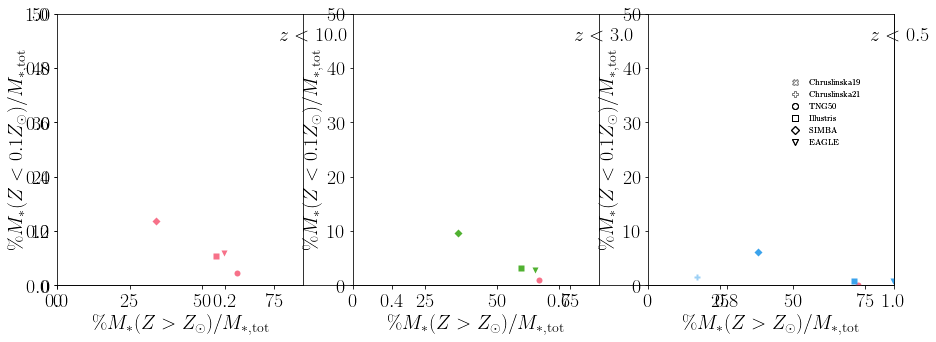

In [105]:
import seaborn as sns
# sns.set_palette(
    
colors = sns.husl_palette(3)


f, ax = plt.subplots(figsize = (15,5))

for ir in range(3):
    ###########
    #add first subplot in layout that has 1 row and 3 columns
    axstr   = '13'+str(ir+1)
    subplot = f.add_subplot(int(axstr))
    ax = subplot
    
    ###########
    # Simulations
    l, = ax.plot( 100 * TNGMass[ir,2] / TNGMass[ir,0], 100 * TNGMass[ir,1] / TNGMass[ir,0], 'o', mec="None", label=None)
    l, = ax.plot( 100 * IllustrisMass[ir,2] / IllustrisMass[ir,0], 100 * IllustrisMass[ir,1] / IllustrisMass[ir,0], 's', mec="None", color=colors[ir] )
    l, = ax.plot( 100 * SimbaMass[ir,2] / SimbaMass[ir,0], 100 * SimbaMass[ir,1] / SimbaMass[ir,0], 'D', mec="None", color=colors[ir] )
    l, = ax.plot( 100 * EagleMass[ir,2] / EagleMass[ir,0], 100 * EagleMass[ir,1] / EagleMass[ir,0], 'v', mec="None", color=colors[ir] )
    
    ###########
    # Observations (Chruslinska)
    l, = ax.plot( np.array(dataChruslinska19_Z10[ir]), np.array(dataChruslinska19_Z01[ir]), 'X', mec="k", mew=0.5, color=colors[ir], alpha=0.5 )
    l, = ax.plot( np.array(dataChruslinska21_Z10[ir]), np.array(dataChruslinska21_Z01[ir]), 'P', mec="None", color=colors[ir], alpha=0.5 )
    
    
    ###########
    # Model
    
    ###########
    # plotvalues
    ax.set_xlabel( "$\% M_* (Z > Z_\odot) / M_\mathrm{*,tot}$" )
    ax.set_ylabel( "$\% M_* (Z < 0.1 Z_\odot) / M_\mathrm{*,tot}$" )
    ax.set_ylim( 0, 50. )
    ax.set_xlim( 0, 85. )
    
    ax.text(0.9, 0.9, '$z<%3.1f$' % TNGBinsRedshift[ir] , transform = ax.transAxes)
#     ax.legend( loc='upper right', frameon=False, scatterpoints=1, numpoints=1, fontsize=7, ncol=3 )

    
###########
# Plot legend in last plot
l, = ax.plot( -1, -1, 'X', alpha=0.3, mfc="None", mec="k" )
l2 = [l]
l, = ax.plot( -1, -1, 'P', alpha=0.3, mfc="None", mec="k" )
l2 += [l]
for m in ['o','s','D','v']:
    l, = ax.plot( -1, -1, m, mfc="None", mec="k" )
    l2 += [l]
legend2 = matplotlib.pyplot.legend( l2, ["$\mathrm{Chruslinska19}$", "$\mathrm{Chruslinska21}$", "$\mathrm{TNG50}$", "$\mathrm{Illustris}$", "$\mathrm{SIMBA}$", "$\mathrm{EAGLE}$", ], loc=(0.55,0.50), frameon=False, numpoints=1, fontsize=8 )
ax.add_artist(legend2)

# f.savefig(str(paths.figures)+ "StellarMassMetallicityTNG%d.pdf" % TNG )
plt.show()



In [73]:
#####################################
# dpdZ_parameters = [mu0_best, muz_best, sigma0_best, sigmaz_best, alpha0_best]
#####################################
mu0_best     = 0.025
muz_best     = -0.049
sigma0_best  = 1.129
sigmaz_best  = 0.048
alpha0_best  = -1.778

#####################################
# sfr_parameters  = [sf_a_best, sf_b_best, sf_c_best, sf_d_best]
#####################################
sf_a_best     = 0.017
sf_b_best     = 1.481
sf_c_best     = 4.452
sf_d_best     = 5.913

np.savetxt(paths.data / 'tesbest_fit_parameters.txt', (mu0_best, muz_best, sigma0_best, sigmaz_best, alpha0_best,sf_a_best, sf_b_best, sf_c_best, sf_d_best),fmt="%s")


In [74]:
mu0_best, muz_best, sigma0_best, sigmaz_best, alpha0_best,sf_a_best, sf_b_best, sf_c_best, sf_d_best = np.loadtxt(paths.data / 'tesbest_fit_parameters.txt',unpack=True)

fid_dpdZ_parameters = [mu0_best, muz_best, sigma0_best, sigmaz_best, alpha0_best]
fid_sfr_parameters  = [sf_a_best, sf_b_best, sf_c_best, sf_d_best]


print(fid_dpdZ_parameters, fid_sfr_parameters)

[0.025, -0.049, 1.129, 0.048, -1.778] [0.017, 1.481, 4.452, 5.913]


In [93]:
import importlib
importlib.reload(Z_SFRD)

redshifts = np.array([0.5, 3, 10])
metals    = np.logspace(-20, 1, num=5000)


def return_ZdepSFRD(mu_0=mu0_best, mu_z=muz_best, sigma_0=sigma0_best, sigma_z =sigmaz_best, alpha = alpha0_best,
                     a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_a_best,
                    metals = metals, redsh = redshifts):
    # Get dPdZ 
    dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                  sigma_0=sigma_0, sigma_z =sigma_z, 
                                                  metals = metals, redsh = redsh)
    # Get the SFR
    sfr        = Z_SFRD.Madau_Dickinson2014(redsh, a=a, b=b, c=c,  d=d) # Msun year-1 Mpc-3 
    # Combine it into a SFRD
    SFRDzZ = (sfr* dPdlogZ.T).value
    return SFRDzZ


SFRDzZ = return_ZdepSFRD()
# print(SFRDzZ, np.shape(SFRDzZ))

Zsun = 0.014
low_Z  = metals < Zsun/10
high_Z = metals > Zsun

for i, z in enumerate(redshifts):
    print('redshift: ', z)
    print('tot SFRD:', sum(SFRDzZ[:,i]))

    print('low Z sfrd:', sum(SFRDzZ[low_Z,i]))
    print('fration at low Z', 100 * sum(SFRDzZ[low_Z,i])/sum(SFRDzZ[:,i]), '%')

    print('high Z sfrd: ', sum(SFRDzZ[high_Z,i]) )
    print('fration at high Z', 100 * sum(SFRDzZ[high_Z,i])/sum(SFRDzZ[:,i]), '%', '\n\n')


redshift:  0.5
tot SFRD: 1.6167974266347032
low Z sfrd: 0.008617597419226372
fration at low Z 0.5330041523608523 %
high Z sfrd:  0.9952106167941704
fration at high Z 61.55444092125135 % 


redshift:  3.0
tot SFRD: 6.8535084925072365
low Z sfrd: 0.3453557091095606
fration at low Z 5.03910820986257 %
high Z sfrd:  2.830767297282023
fration at high Z 41.30391463550133 % 


redshift:  10.0
tot SFRD: 30.3960877987072
low Z sfrd: 17.412100509762432
fration at low Z 57.284018341672905 %
high Z sfrd:  3.264833878981746
fration at high Z 10.740967392259623 % 


